
# Step 3 – Regression Analysis  
Swiss Household Panel (2019–2023)

**Input:** analysis_dataset_step2_clean.csv  
**Goal:** Estimate relationship between sports participation, income, and health


In [1]:
%pip install statsmodels
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

pd.set_option("display.max_columns", 200)


In [3]:

# Load cleaned analysis dataset
df = pd.read_csv("analysis_dataset_step2_clean.csv")
print("Loaded shape:", df.shape)
df.head()


Loaded shape: (55624, 17)


,idpers,idhous,year,wave,age,female,education_years,isced,sport_raw,sport_active,sport_level,health_raw,health_good,income_imputed,log_income,household_size,num_children
0,5101,51,2019,21,58.0,0,19.0,51.0,2.0,1,low,2.0,1,117000.0,11.669929,NaN,NaN
1,5103,52,2019,21,27.0,0,9.0,20.0,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN
2,5104,51,2019,21,58.0,1,12.0,32.0,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN
3,5201,52,2019,21,25.0,1,12.0,32.0,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN
4,13101,131,2019,21,47.0,0,12.0,32.0,NaN,0,NaN,NaN,0,NaN,NaN,NaN,NaN


In [4]:

# --------------------------------------------------
# Descriptive overview
# --------------------------------------------------
df[["sport_active","health_good"]].mean()

df[["log_income"]].describe()


,log_income
count,40064.000000
mean,10.911786
std,1.028231
min,4.605170
25%,10.513253
50%,11.086747
75%,11.512925
max,16.518616


In [5]:
# 1) genau die Variablen des Modells definieren
vars_m1 = ["log_income", "sport_active", "age", "female", "education_years", "health_good", "idpers"]

# 2) rows mit fehlenden Werten entfernen (so wie statsmodels es sonst intern macht)
df_m1 = df[vars_m1].dropna().copy()

# 3) fit mit clustered SE (jetzt gleiche Länge!)
model1 = smf.ols(
    "log_income ~ sport_active + age + female + education_years + health_good",
    data=df_m1
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_m1["idpers"]}
)

print(model1.summary())
print("N used:", int(model1.nobs))


                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.267
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     1047.
Date:                Sun, 18 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:33:45   Log-Likelihood:                -51511.
No. Observations:               39944   AIC:                         1.030e+05
Df Residuals:                   39938   BIC:                         1.031e+05
Df Model:                           5                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.9029      0.045    1

In [6]:
vars_m2 = ["log_income", "sport_active", "age", "female", "education_years", "health_good", "year", "idpers"]
df_m2 = df[vars_m2].dropna().copy()

model2 = smf.ols(
    "log_income ~ sport_active + age + female + education_years + health_good + C(year)",
    data=df_m2
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_m2["idpers"]}
)

print(model2.summary())
print("N used:", int(model2.nobs))


                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.268
Method:                 Least Squares   F-statistic:                     608.9
Date:                Sun, 18 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:33:45   Log-Likelihood:                -51490.
No. Observations:               39944   AIC:                         1.030e+05
Df Residuals:                   39934   BIC:                         1.031e+05
Df Model:                           9                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.8493      0.046    1

In [7]:

# --------------------------------------------------
# Model 3: Individual Fixed Effects
# --------------------------------------------------
# demean variables by individual (within estimator)

vars_fe = ["log_income","sport_active","age","health_good"]

df_fe = df.dropna(subset=vars_fe).copy()

df_fe[vars_fe] = df_fe[vars_fe] - df_fe.groupby("idpers")[vars_fe].transform("mean")

model3 = smf.ols(
    formula="log_income ~ sport_active + age + health_good",
    data=df_fe
).fit(cov_type="HC3")

print(model3.summary())


                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     284.3
Date:                Sun, 18 Jan 2026   Prob (F-statistic):          1.33e-182
Time:                        18:33:45   Log-Likelihood:                -21200.
No. Observations:               40064   AIC:                         4.241e+04
Df Residuals:                   40060   BIC:                         4.244e+04
Df Model:                           3                                         
Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1.214e-17      0.002   5.92e-15   

In [8]:
# --- define variables ---
base_vars = ["log_income","sport_active","age","female","education_years","health_good","year","idpers"]

# common sample for (1) & (2)
df_common = df[base_vars].dropna().copy()

# (1) pooled OLS with clustered SE
m1 = smf.ols(
    "log_income ~ sport_active + age + female + education_years + health_good",
    data=df_common
).fit(cov_type="cluster", cov_kwds={"groups": df_common["idpers"]})

# (2) year FE with clustered SE
m2 = smf.ols(
    "log_income ~ sport_active + age + female + education_years + health_good + C(year)",
    data=df_common
).fit(cov_type="cluster", cov_kwds={"groups": df_common["idpers"]})

# (3) individual FE (within) + year FE
fe_vars = ["log_income","sport_active","age","health_good","year","idpers"]
df_fe = df[fe_vars].dropna().copy()

# within-transform
for v in ["log_income","sport_active","age","health_good"]:
    df_fe[v] = df_fe[v] - df_fe.groupby("idpers")[v].transform("mean")

m3 = smf.ols(
    "log_income ~ sport_active + age + health_good + C(year)",
    data=df_fe
).fit(cov_type="cluster", cov_kwds={"groups": df_fe["idpers"]})

print("N common (m1/m2):", int(m1.nobs))
print("N FE (m3):", int(m3.nobs))


N common (m1/m2): 39944
N FE (m3): 40064


In [9]:
def star(p):
    if pd.isna(p): return ""
    if p < 0.01: return "***"
    if p < 0.05: return "**"
    if p < 0.10: return "*"
    return ""

def detect_cols(t):
    coef_col = next((c for c in ["Coef.","coef"] if c in t.columns), t.columns[0])
    se_col   = next((c for c in ["Std.Err.","std err","Std. Err."] if c in t.columns), None)
    p_col    = next((c for c in ["P>|t|","P>|z|","P-value"] if c in t.columns), None)
    return coef_col, se_col, p_col

def paper_table(models, names, var_order, labels=None, add_rows=None, digits=3):
    if labels is None: labels = {}
    if add_rows is None: add_rows = {}

    idx = []
    for v in var_order:
        idx += [labels.get(v, v), ""]  # coef row label, then blank row for SE
    idx += list(add_rows.keys())

    out = pd.DataFrame(index=idx, columns=names, dtype="object")

    for m, nm in zip(models, names):
        t = m.summary2().tables[1].copy()
        coef_col, se_col, p_col = detect_cols(t)

        for v in var_order:
            lab = labels.get(v, v)
            if v in t.index:
                b  = float(t.loc[v, coef_col])
                se = float(t.loc[v, se_col]) if (se_col and se_col in t.columns) else np.nan
                p  = float(t.loc[v, p_col]) if (p_col and p_col in t.columns) else np.nan

                out.loc[lab, nm] = f"{b:.{digits}f}{star(p)}"
                out.loc["", nm]  = f"({se:.{digits}f})" if pd.notna(se) else ""
            else:
                out.loc[lab, nm] = ""
                out.loc["", nm]  = ""

        # add extra rows (N, R2, FE flags, etc.)
        for rname, rfunc in add_rows.items():
            out.loc[rname, nm] = rfunc(m)

    return out

labels = {
    "sport_active": "Sport active (dummy)",
    "age": "Age",
    "female": "Female",
    "education_years": "Education years",
    "health_good": "Good health (dummy)"
}

add_rows = {
    "N": lambda m: f"{int(m.nobs)}",
    "R²": lambda m: f"{getattr(m,'rsquared', np.nan):.3f}",
    "Year FE": lambda m: "Yes" if "C(year)" in str(m.model.formula) else "No",
    "Ind. FE": lambda m: "Yes" if m is m3 else "No",
    "SE clustered by id": lambda m: "Yes"
}

tbl = paper_table(
    models=[m1, m2, m3],
    names=["(1) Pooled OLS", "(2) Year FE", "(3) Ind FE + Year FE"],
    var_order=["sport_active","age","female","education_years","health_good"],
    labels=labels,
    add_rows=add_rows,
    digits=3
)

tbl




,(1) Pooled OLS,(2) Year FE,(3) Ind FE + Year FE
Sport active (dummy),-0.078***,-0.077***,-0.017
,(0.016),(0.016),(0.012)
Age,0.023***,0.023***,0.055***
,(0.016),(0.016),(0.012)
Female,-0.503***,-0.502***,
,(0.016),(0.016),(0.012)
Education years,0.087***,0.087***,
,(0.016),(0.016),(0.012)
Good health (dummy),0.035**,0.038**,-0.019*
,(0.016),(0.016),(0.012)


In [10]:
print("Notes: Clustered standard errors at individual level in parentheses. * p<0.10, ** p<0.05, *** p<0.01.")
print("Dependent variable: log(income).")


Notes: Clustered standard errors at individual level in parentheses. * p<0.10, ** p<0.05, *** p<0.01.
Dependent variable: log(income).


In [11]:
df_common2 = df[["log_income","sport_raw","age","female","education_years","health_good","year","idpers"]].dropna().copy()

m2_dose = smf.ols(
    "log_income ~ sport_raw + age + female + education_years + health_good + C(year)",
    data=df_common2
).fit(cov_type="cluster", cov_kwds={"groups": df_common2["idpers"]})

print(m2_dose.summary())


                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     583.2
Date:                Sun, 18 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:33:46   Log-Likelihood:                -39718.
No. Observations:               31606   AIC:                         7.946e+04
Df Residuals:                   31596   BIC:                         7.954e+04
Df Model:                           9                                         
Covariance Type:              cluster                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           8.7659      0.050    1

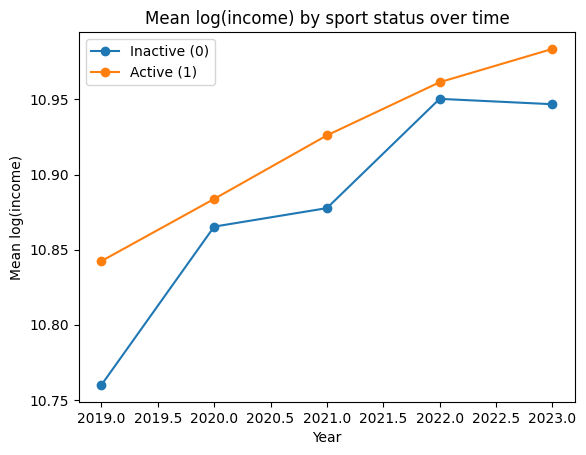

In [12]:
import matplotlib.pyplot as plt

tmp = df.dropna(subset=["log_income","sport_active","year"]).copy()
g = tmp.groupby(["year","sport_active"])["log_income"].mean().unstack()

g.plot(kind="line", marker="o")
plt.title("Mean log(income) by sport status over time")
plt.xlabel("Year")
plt.ylabel("Mean log(income)")
plt.legend(["Inactive (0)", "Active (1)"])
plt.show()


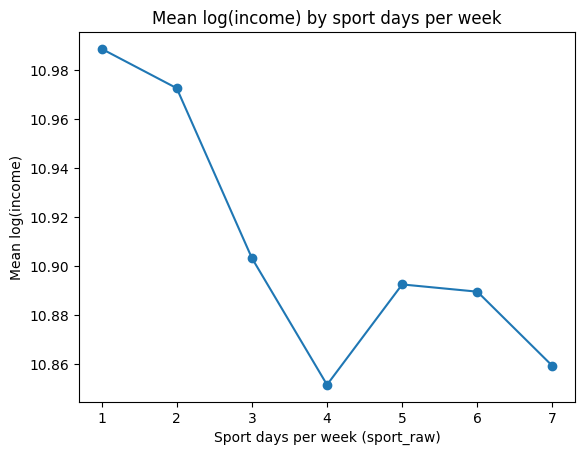

In [13]:
tmp = df.dropna(subset=["sport_raw","log_income"]).copy()

# bins by sport_raw (0..7) – means per bin
b = tmp.groupby("sport_raw")["log_income"].mean()

plt.plot(b.index, b.values, marker="o")
plt.title("Mean log(income) by sport days per week")
plt.xlabel("Sport days per week (sport_raw)")
plt.ylabel("Mean log(income)")
plt.show()


In [14]:

# --------------------------------------------------
# Interpretation helper
# --------------------------------------------------
beta = model2.params["sport_active"]
effect_pct = (np.exp(beta) - 1) * 100

print(f"Sport-active individuals earn on average {effect_pct:.1f}% more (Year FE model).")


Sport-active individuals earn on average -7.4% more (Year FE model).


In [15]:
# ------------------------------------
# TABLE 1: Descriptive Statistics
# ------------------------------------

vars_desc = [
    "income_imputed",
    "log_income",
    "sport_active",
    "sport_raw",
    "age",
    "female",
    "education_years",
    "health_good"
]

desc = df[vars_desc].describe().T
desc = desc[["mean", "std", "min", "max", "count"]]
desc = desc.rename(columns={
    "mean": "Mean",
    "std": "Std. Dev.",
    "min": "Min",
    "max": "Max",
    "count": "N"
})

desc


,Mean,Std. Dev.,Min,Max,N
income_imputed,80458.768984,140028.952201,0.00000,1.492601e+07,41298.0
log_income,10.911786,1.028231,4.60517,1.651862e+01,40064.0
sport_active,0.583975,0.492902,0.00000,1.000000e+00,55624.0
sport_raw,3.396207,1.826665,1.00000,7.000000e+00,32483.0
age,42.721577,14.039672,18.00000,6.400000e+01,55624.0
female,0.512189,0.499856,0.00000,1.000000e+00,55624.0
education_years,14.405818,3.582757,0.00000,2.100000e+01,54931.0
health_good,0.632263,0.482194,0.00000,1.000000e+00,55624.0
